# Задание 5

Дана выборка: https://drive.google.com/file/d/1cMqd315q_eR_x2oH5LsUTvVvAaODct-F/view?usp=sharing regression_x_train.npy, regression_x_test.npy, regression_y_train.npy

Выборка состоит из трех обзектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

   1. Провести отбор наиболее значимых признаков и построить регрессию X->Y
   2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
   3. Получить изображение по X_test


# Импорт основных библиотек

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import cm
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

# Загрузка данных

In [2]:
data_x_train = np.load('./regression_x_train.npy')
data_y_train = np.load('./regression_y_train.npy')
data_x_test = np.load('./regression_x_test.npy')
print(data_x_train.shape)
print(data_y_train.shape)
print(data_x_test.shape)

(286, 604, 35)
(286, 604)
(420, 620, 35)


Посмотрим на картинку $y\_train$.

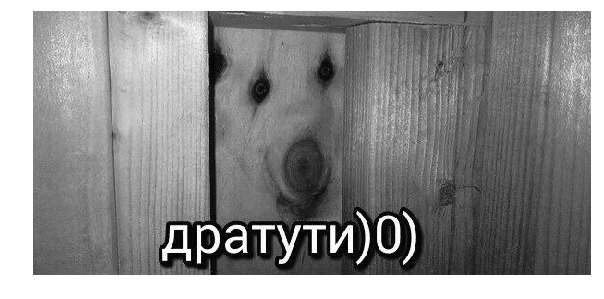

In [3]:
def show_img(img):
    """
    Красиво выводит картинку с помощью matplotlib
    """
    plt.figure(figsize=(10, 6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cm.Greys_r)
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()
    
show_img(data_y_train)

Соберём наши данные в один массив $X\_train, y\_train$, по которому будем обучать регрессию.

In [4]:
train_len_x = data_x_train.shape[0]
train_len_y = data_x_train.shape[1]
test_len_x = data_x_test.shape[0]
test_len_y = data_x_test.shape[1]

X_train = []
y_train = []
for i in range(train_len_x):
    for j in range(train_len_y):
        X_train.append(data_x_train[i][j])
        y_train.append(data_y_train[i][j])
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [5]:
X_train[0]

array([ 4.96714153e-01, -1.38264301e-01,  1.64768854e+00,  2.28854900e+00,
        8.59431137e-01, -7.02410871e-02,  4.73763845e-01,  1.23023042e+00,
        6.24676826e-01,  1.25635252e+00,  5.44733522e+00,  1.48588349e+01,
        2.88740540e+01,  9.62871886e+02,  3.61391494e+01,  1.71745956e+01,
        9.17664425e+01,  8.74765711e+01,  2.88478687e+01,  1.67077128e+02,
        4.91997263e+02,  2.08234417e+02,  6.46764108e+00,  1.34644964e+02,
        9.77187279e+01,  1.38643103e+02,  4.56076232e+01,  3.87500303e+01,
        1.47605407e+02,  2.52427767e+02, -6.01706612e-01,  1.85227818e+00,
       -1.34972247e-02, -1.05771093e+00,  8.22544912e-01])

In [6]:
features = data_x_train.shape[2]
X_train_dict = {'Y': y_train}
for i in range(features):
    cur_string = str(i)
    X_train_dict[cur_string] = X_train[:, i]
    
train_df = pd.DataFrame(X_train_dict)

In [7]:
train_df.head()

,Y,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,0.658741,0.496714,-0.138264,1.647689,2.288549,0.859431,-0.070241,0.473764,1.23023,0.624677,...,138.643103,45.607623,38.750030,147.605407,252.427767,-0.601707,1.852278,-0.013497,-1.057711,0.822545
1,0.671523,0.496714,-0.138264,1.647689,2.293655,-0.079660,-0.070241,0.473764,1.23023,0.629783,...,139.352788,17.831804,15.150602,57.711200,98.694957,-0.601707,1.852278,-0.013497,-1.057711,0.822545
2,0.660211,0.496714,-0.138264,1.647689,2.296195,1.243614,-0.070241,0.473764,1.23023,0.632323,...,139.707226,66.970839,56.901059,216.745739,370.668282,-0.601707,1.852278,-0.013497,-1.057711,0.822545
3,0.662597,0.496714,-0.138264,1.647689,2.296195,0.714635,-0.070241,0.473764,1.23023,0.632323,...,139.707226,39.459637,33.526459,127.707943,218.400068,-0.601707,1.852278,-0.013497,-1.057711,0.822545
4,0.658827,0.496714,-0.138264,1.647689,2.288549,0.422087,-0.070241,0.473764,1.23023,0.624677,...,138.643103,29.451076,25.022793,95.316041,163.004973,-0.601707,1.852278,-0.013497,-1.057711,0.822545


# Отбор признаков

Посмотрим на попарные признаки. 

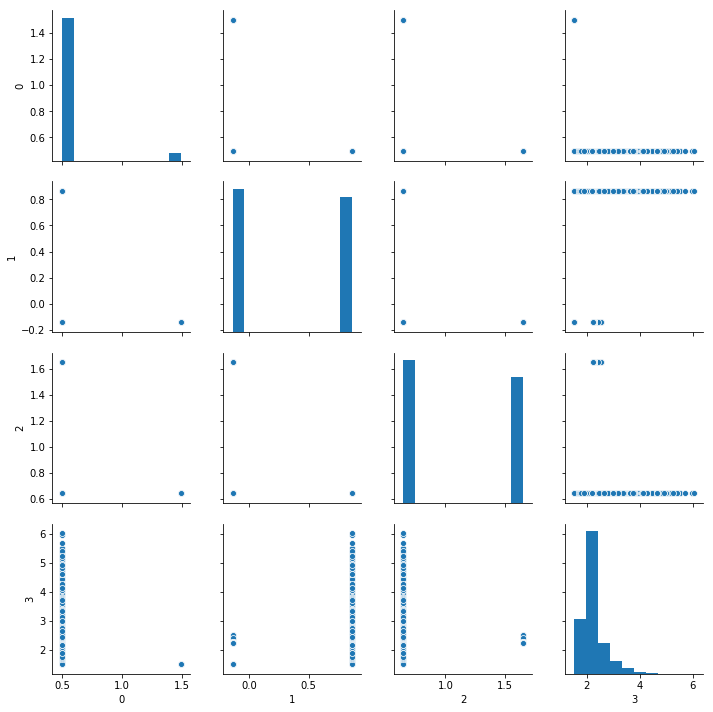

In [8]:
sns.pairplot(train_df[['0', '1', '2', '3']])

Кажется, что значений некоторых признаков достаточно мало. Выведем для каждого признака количество уникальных значений.

In [9]:
for i in range(features):
    cur_str = str(i)
    print(len(pd.unique(train_df[cur_str])))

2
2
2
98899
100611
2
2
2
98899
100611
2
2
2
2
2
2
2
2
2
2
2
2
98899
98899
98899
98899
100611
100611
100611
100611
1
1
1
1
1


Видно, что $5$ последних признаков принимают всего лишь $1$ значение, $18$ признаков бинарные. Проверим это на тесте.

In [10]:
X_test = []
for i in range(test_len_x):
    for j in range(test_len_y):
        X_test.append(data_x_test[i][j])
        
X_test = np.array(X_test)
for i in range(features):
    print(np.unique(X_test[:, i]).shape[0])

2
2
2
146631
159949
2
2
2
146631
159949
2
2
2
2
2
2
2
2
2
2
2
2
146631
146631
146631
146631
159949
159949
159949
159949
1
1
1
1
1


In [11]:
for i in range(features - 5, features):
    print(X_train[:, i][0] == X_test[:, i][0])

True
True
True
True
True


Итак, последние 5 признаков константные, а значит неинформативные, их можно отбросить.

In [12]:
train_df_copy = train_df
train_df_inform = train_df_copy.drop(['30', '31', '32', '33', '34'], 1)

In [13]:
train_df_inform.head()

,Y,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0.658741,0.496714,-0.138264,1.647689,2.288549,0.859431,-0.070241,0.473764,1.23023,0.624677,...,491.997263,208.234417,6.467641,134.644964,97.718728,138.643103,45.607623,38.750030,147.605407,252.427767
1,0.671523,0.496714,-0.138264,1.647689,2.293655,-0.079660,-0.070241,0.473764,1.23023,0.629783,...,491.997263,208.234417,6.500748,135.334184,98.218930,139.352788,17.831804,15.150602,57.711200,98.694957
2,0.660211,0.496714,-0.138264,1.647689,2.296195,1.243614,-0.070241,0.473764,1.23023,0.632323,...,491.997263,208.234417,6.517282,135.678401,98.468746,139.707226,66.970839,56.901059,216.745739,370.668282
3,0.662597,0.496714,-0.138264,1.647689,2.296195,0.714635,-0.070241,0.473764,1.23023,0.632323,...,491.997263,208.234417,6.517282,135.678401,98.468746,139.707226,39.459637,33.526459,127.707943,218.400068
4,0.658827,0.496714,-0.138264,1.647689,2.288549,0.422087,-0.070241,0.473764,1.23023,0.624677,...,491.997263,208.234417,6.467641,134.644964,97.718728,138.643103,29.451076,25.022793,95.316041,163.004973


Посмотрим для сравнения на попарные признаки в тесте.

In [14]:
features = data_x_test.shape[2]
X_test_dict = {}
for i in range(features):
    cur_string = str(i)
    X_test_dict[cur_string] = X_test[:, i]
    
test_df = pd.DataFrame(X_test_dict)

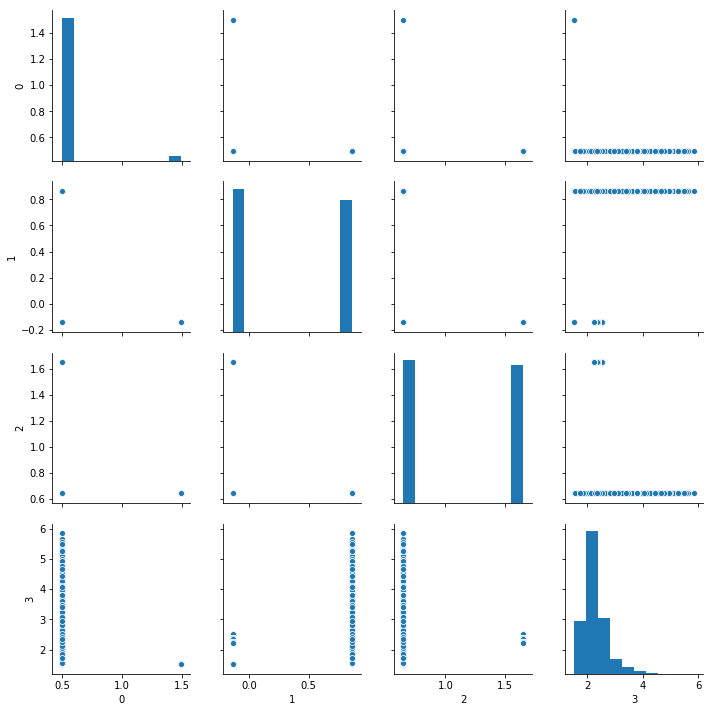

In [15]:
sns.pairplot(test_df[['0', '1', '2', '3']])

Попробуем понять природу бинарных признаков. Сначала для train.

In [16]:
bin_features = []
for i in range(features):
    cur_str = str(i)
    cur_arr = pd.unique(train_df[cur_str])
    if len(cur_arr) == 2:
        bin_features.append(i)
        print('Номер признака = {0}, значения = {1}, {2}'.format(i, cur_arr[0], cur_arr[1]))

Номер признака = 0, значения = 0.4967141530112327, 1.4967141530112327
Номер признака = 1, значения = -0.13826430117118466, 0.8617356988288154
Номер признака = 2, значения = 1.6476885381006925, 0.6476885381006925
Номер признака = 5, значения = -0.07024108708475416, 0.9297589129152458
Номер признака = 6, значения = 0.47376384465221744, 1.4737638446522174
Номер признака = 7, значения = 1.2302304187458726, 0.23023041874587263
Номер признака = 10, значения = 5.447335223145896, 14.807392350602386
Номер признака = 11, значения = 14.85883488891553, 40.39050087061236
Номер признака = 12, значения = 28.87405402738814, 78.4878163765939
Номер признака = 13, значения = 962.8718863692098, 2617.357151851506
Номер признака = 14, значения = 36.13914940471159, 98.23639312279403
Номер признака = 15, значения = 17.174595632318848, 46.68539121846441
Номер признака = 16, значения = 91.76644248291785, 249.44705306364776
Номер признака = 17, значения = 87.47657112101957, 237.7859736941728
Номер признака = 18,

Теперь для test.

In [17]:
bin_features_test = []
for i in range(features):
    cur_str = str(i)
    cur_arr = pd.unique(test_df[cur_str])
    if len(cur_arr) == 2:
        bin_features_test.append(i)
        print('Номер признака = {0}, значения = {1}, {2}'.format(i, cur_arr[0], cur_arr[1]))

Номер признака = 0, значения = 0.4967141530112327, 1.4967141530112327
Номер признака = 1, значения = 0.8617356988288154, -0.13826430117118466
Номер признака = 2, значения = 0.6476885381006925, 1.6476885381006925
Номер признака = 5, значения = -0.07024108708475416, 0.9297589129152458
Номер признака = 6, значения = 1.4737638446522174, 0.47376384465221744
Номер признака = 7, значения = 0.23023041874587263, 1.2302304187458726
Номер признака = 10, значения = 5.447335223145896, 14.807392350602386
Номер признака = 11, значения = 14.85883488891553, 40.39050087061236
Номер признака = 12, значения = 28.87405402738814, 78.4878163765939
Номер признака = 13, значения = 962.8718863692098, 2617.357151851506
Номер признака = 14, значения = 98.23639312279403, 36.13914940471159
Номер признака = 15, значения = 46.68539121846441, 17.174595632318848
Номер признака = 16, значения = 249.44705306364776, 91.76644248291785
Номер признака = 17, значения = 237.7859736941728, 87.47657112101957
Номер признака = 18,

Видим, что значения для соответствующих бинарных признаков в train и test совпадают. Более того, для признаков с номерами $0, 1, 2, 5, 6, 7$ хорошо видно, что разность между их возможными значениями близка к $1$, а отношение возможных значений для признаков с номерами от $10$ до $21$ близко к какой-то константе. Проверим это. 

In [18]:
for i in [0, 1, 2, 5, 6, 7]:
    cur_str = str(i)
    cur_arr = pd.unique(train_df[cur_str])
    print('Номер признака = {0}, абсолютное значение разности = {1}'.format(i, abs(cur_arr[0]-cur_arr[1])))

Номер признака = 0, абсолютное значение разности = 1.0
Номер признака = 1, абсолютное значение разности = 1.0
Номер признака = 2, абсолютное значение разности = 1.0
Номер признака = 5, абсолютное значение разности = 1.0
Номер признака = 6, абсолютное значение разности = 1.0
Номер признака = 7, абсолютное значение разности = 1.0


In [19]:
for i in range(10, 22):
    cur_str = str(i)
    cur_arr = pd.unique(train_df[cur_str])
    if (cur_arr[0] > cur_arr[1]):
        print('Номер признака = {0}, отношение возможных значений = {1}'.format(i, cur_arr[0]/cur_arr[1]))
    else:
        print('Номер признака = {0}, отношение возможных значений = {1}'.format(i, cur_arr[1]/cur_arr[0]))

Номер признака = 10, отношение возможных значений = 2.718281828459045
Номер признака = 11, отношение возможных значений = 2.718281828459045
Номер признака = 12, отношение возможных значений = 2.7182818284590455
Номер признака = 13, отношение возможных значений = 2.7182818284590455
Номер признака = 14, отношение возможных значений = 2.718281828459045
Номер признака = 15, отношение возможных значений = 2.718281828459045
Номер признака = 16, отношение возможных значений = 2.7182818284590455
Номер признака = 17, отношение возможных значений = 2.7182818284590455
Номер признака = 18, отношение возможных значений = 2.718281828459045
Номер признака = 19, отношение возможных значений = 2.718281828459045
Номер признака = 20, отношение возможных значений = 2.718281828459045
Номер признака = 21, отношение возможных значений = 2.718281828459045


Получилась хорошее приближение числа Эйлера =) Попробуем визуализировать области бинаризации, то есть для каждого бинарного признака поместим в значение пикселя число $0$ или $1$ в зависимости от значения бинарного признака, а потом нарисуем картинку. 

Признак 0, возможные значения = 0.4967141530112327 и 1.4967141530112327


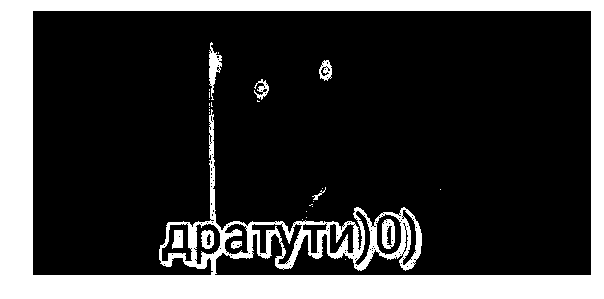

Признак 1, возможные значения = -0.13826430117118466 и 0.8617356988288154


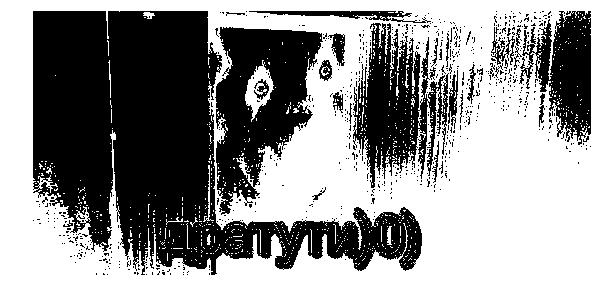

Признак 2, возможные значения = 1.6476885381006925 и 0.6476885381006925


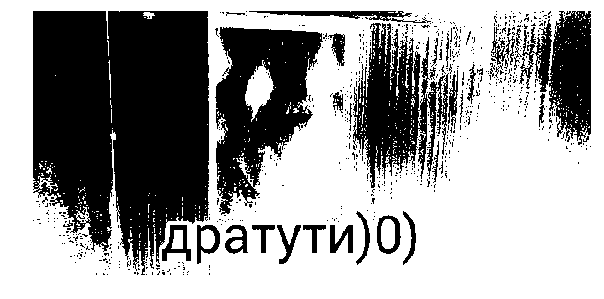

Признак 5, возможные значения = -0.07024108708475416 и 0.9297589129152458


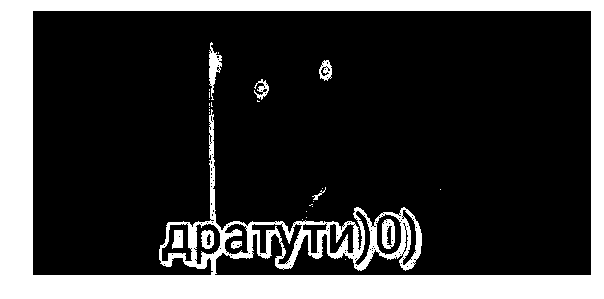

Признак 6, возможные значения = 0.47376384465221744 и 1.4737638446522174


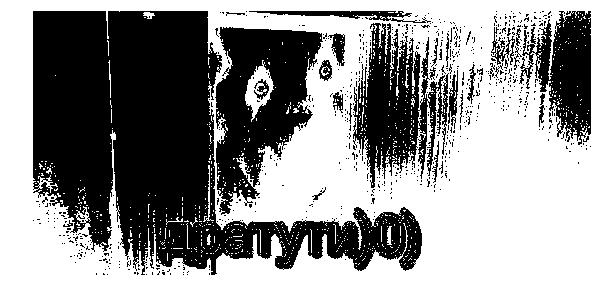

Признак 7, возможные значения = 1.2302304187458726 и 0.23023041874587263


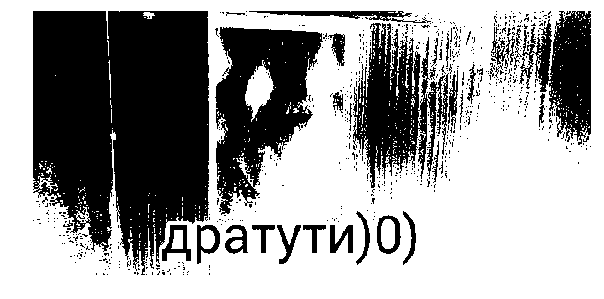

Признак 10, возможные значения = 5.447335223145896 и 14.807392350602386


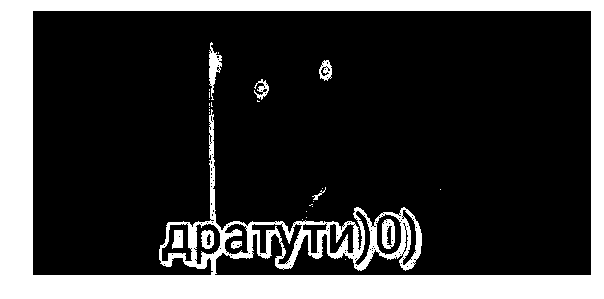

Признак 11, возможные значения = 14.85883488891553 и 40.39050087061236


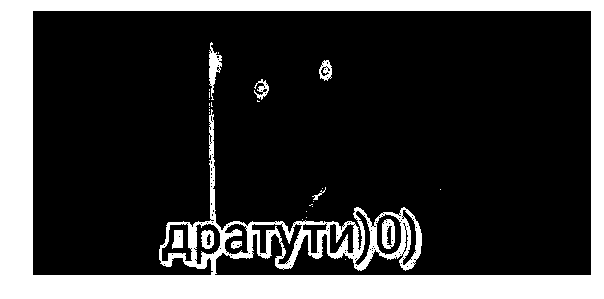

Признак 12, возможные значения = 28.87405402738814 и 78.4878163765939


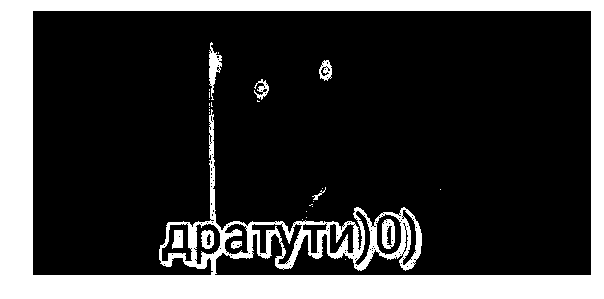

Признак 13, возможные значения = 962.8718863692098 и 2617.357151851506


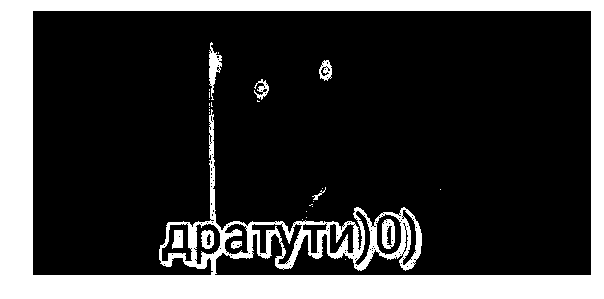

Признак 14, возможные значения = 36.13914940471159 и 98.23639312279403


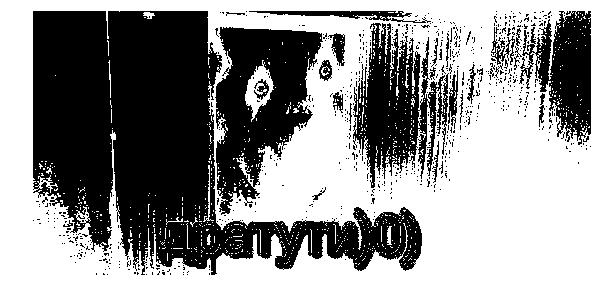

Признак 15, возможные значения = 17.174595632318848 и 46.68539121846441


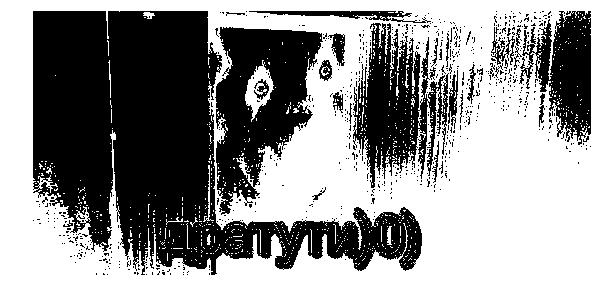

Признак 16, возможные значения = 91.76644248291785 и 249.44705306364776


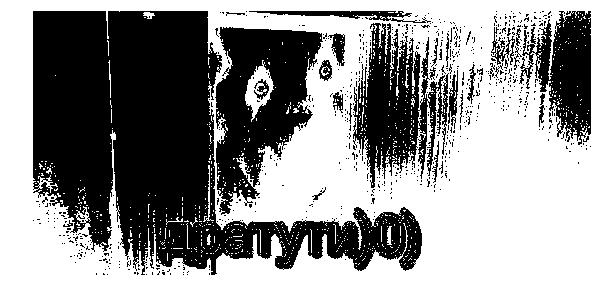

Признак 17, возможные значения = 87.47657112101957 и 237.7859736941728


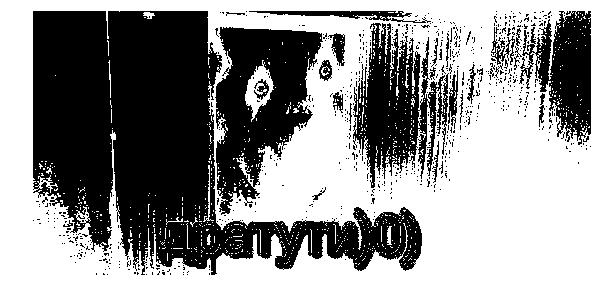

Признак 18, возможные значения = 28.84786865018706 и 10.612537798017986


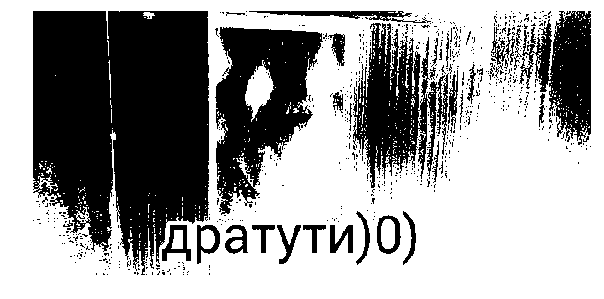

Признак 19, возможные значения = 167.07712831612037 и 61.46424059746372


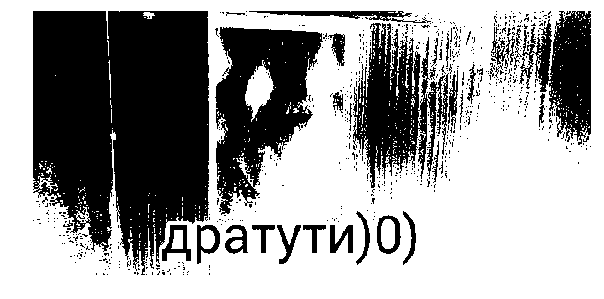

Признак 20, возможные значения = 491.99726295750435 и 180.99567815468586


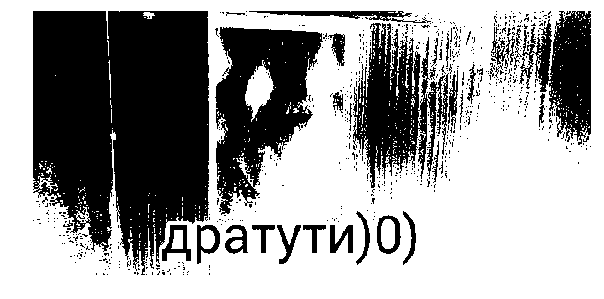

Признак 21, возможные значения = 208.23441716949512 и 76.60516102097486


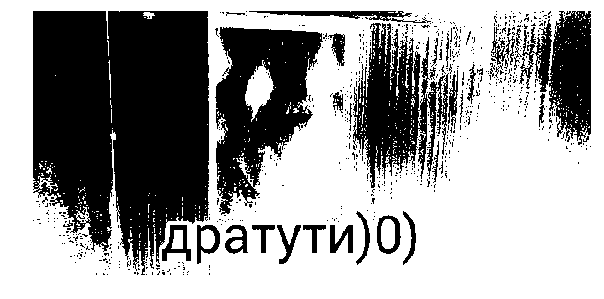

In [87]:
for features in bin_features:
    cur_str = str(features)
    cur_arr = pd.unique(train_df[cur_str])
    val_1 = cur_arr[0]
    val_2 = cur_arr[1]
    print("Признак {0}, возможные значения = {1} и {2}".format(features, val_1, val_2))
    y_plot = np.zeros((data_y_train.shape[0], data_y_train.shape[1]))
    for i in range(train_len_x):
        for j in range(train_len_y):
            if data_x_train[i][j][features] == val_1:
                y_plot[i][j] = 0
            else:
                y_plot[i][j] = 1
    show_img(y_plot)

Мне кажется, что всего у нас получается три типа картинок:

1) первый тип для признаков $0, 5, 10, 11, 12, 13$

2) второй тип для признаков $1, 6, 14, 15, 16, 17$

3) третий тип для признаков $2, 7, 18, 19, 20, 21$

Попробуем проинтерпретировать их, для чего ещё раз посмотрим на исходную картинку.

In [81]:
bin_features_1 = [0, 5, 10, 11, 12, 13]
bin_features_2 = [1, 6, 14, 15, 16, 17]
bin_features_3 = [2, 7, 18, 19, 20, 21]

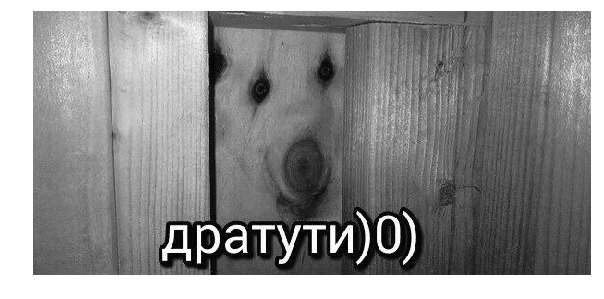

In [80]:
show_img(data_y_train)

Я бы проинтерпретировал их так: 

1) признаки $0, 5, 10, 11, 12, 13$ получаются бинарно в зависимости от "чёрности" пикселя - если достаточно чёрные, то имеют одно значение, иначе - другое, причём порог достаточно большой.

Кажется, что остальных 2 типов признаков ситуация аналогичная.

Попробуем отобразить зависимость между значением в пикселе и рассматриваемыми бинарными признаками.

Признак 0, возможные значения = 0.4967141530112327 и 1.4967141530112327


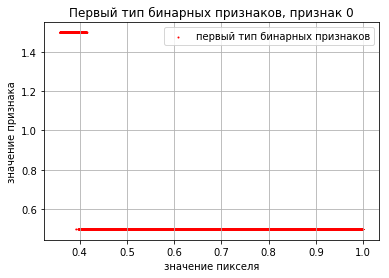

Признак 5, возможные значения = -0.07024108708475416 и 0.9297589129152458


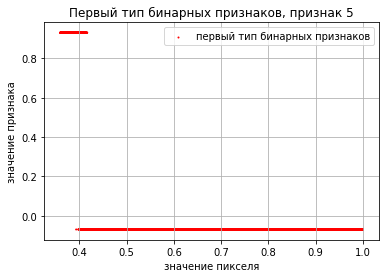

Признак 10, возможные значения = 5.447335223145896 и 14.807392350602386


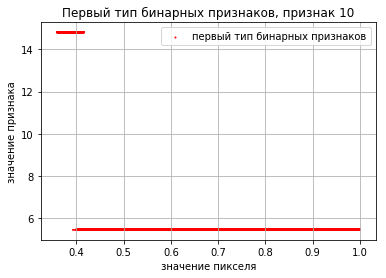

Признак 11, возможные значения = 14.85883488891553 и 40.39050087061236


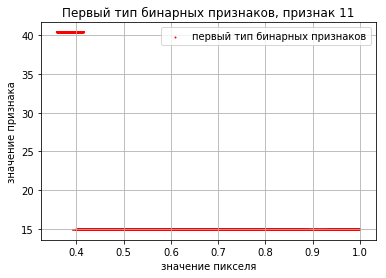

Признак 12, возможные значения = 28.87405402738814 и 78.4878163765939


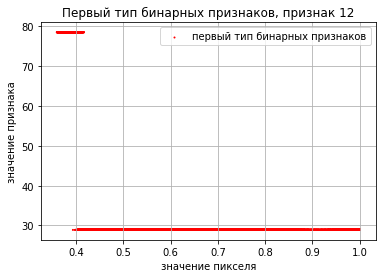

Признак 13, возможные значения = 962.8718863692098 и 2617.357151851506


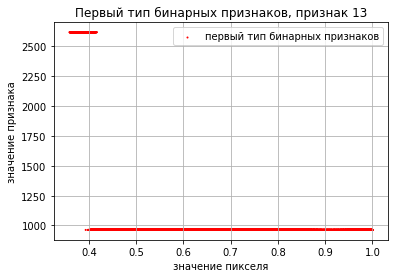

In [89]:
for features in bin_features_1:
    cur_str = str(features)
    cur_arr = pd.unique(train_df[cur_str])
    val_1 = cur_arr[0]
    val_2 = cur_arr[1]
    print("Признак {0}, возможные значения = {1} и {2}".format(features, val_1, val_2))
    x_axis = train_df['Y']
    y_axis = train_df[cur_str]
    fig = plt.figure()

    plt.xlabel('значение пикселя') 
    plt.ylabel('значение признака') 
    plt.title('Первый тип бинарных признаков, признак {0}'.format(features)) 

    s = [1 for n in range(x_axis.shape[0])]
    plt.scatter(x_axis, y_axis, label = 'первый тип бинарных признаков', s = s, color = 'r')

    plt.legend()
    plt.grid(True) 
    plt.show()

Здесь видно, что для этого типа признаков практически для всех пикселей порог равен около $0.4$, для некоторых пикселей это правило не выполняется, возможно потому, что для на них наложен какой-то шум.

Посмотрим аналогичную ситуацию для следующих групп признаков.

Признак 1, возможные значения = -0.13826430117118466 и 0.8617356988288154


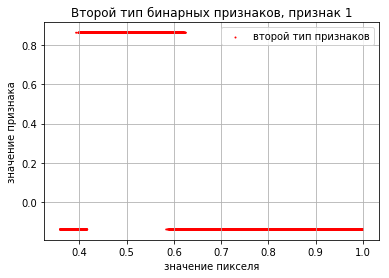

Признак 6, возможные значения = 0.47376384465221744 и 1.4737638446522174


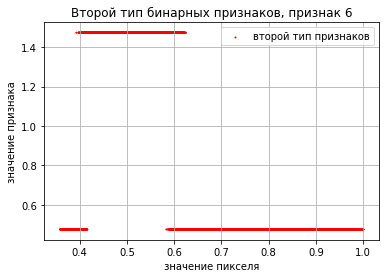

Признак 14, возможные значения = 36.13914940471159 и 98.23639312279403


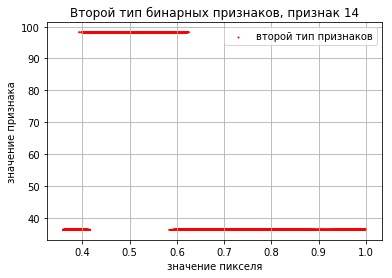

Признак 15, возможные значения = 17.174595632318848 и 46.68539121846441


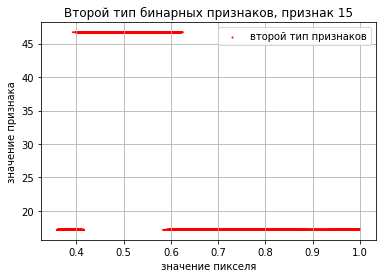

Признак 16, возможные значения = 91.76644248291785 и 249.44705306364776


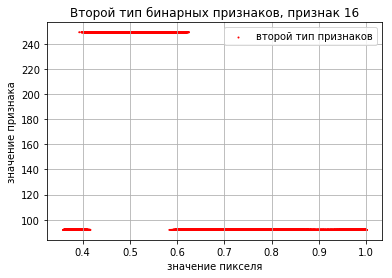

Признак 17, возможные значения = 87.47657112101957 и 237.7859736941728


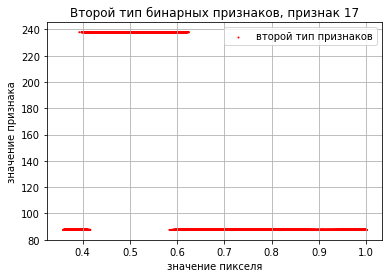

In [90]:
for features in bin_features_2:
    cur_str = str(features)
    cur_arr = pd.unique(train_df[cur_str])
    val_1 = cur_arr[0]
    val_2 = cur_arr[1]
    print("Признак {0}, возможные значения = {1} и {2}".format(features, val_1, val_2))
    x_axis = train_df['Y']
    y_axis = train_df[cur_str]
    fig = plt.figure()

    plt.xlabel('значение пикселя') 
    plt.ylabel('значение признака') 
    plt.title('Второй тип бинарных признаков, признак {0}'.format(features)) 

    s = [1 for n in range(x_axis.shape[0])]
    plt.scatter(x_axis, y_axis, label = 'второй тип признаков', s = s, color = 'r')

    plt.legend()
    plt.grid(True) 
    plt.show()

Здесь ситуация аналогичная, но порогов уже два, оба тоже размытые, около $0.4$ и $0.6$.

Смотрим на $3$ группу признаков. 

Признак 2, возможные значения = 1.6476885381006925 и 0.6476885381006925


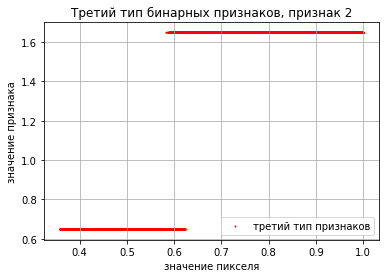

Признак 7, возможные значения = 1.2302304187458726 и 0.23023041874587263


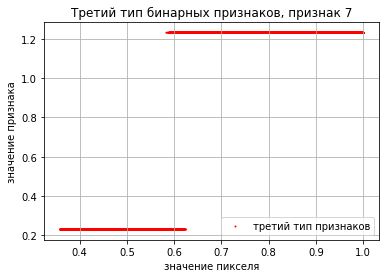

Признак 18, возможные значения = 28.84786865018706 и 10.612537798017986


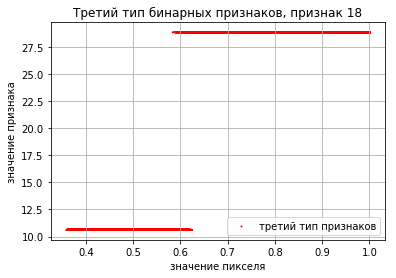

Признак 19, возможные значения = 167.07712831612037 и 61.46424059746372


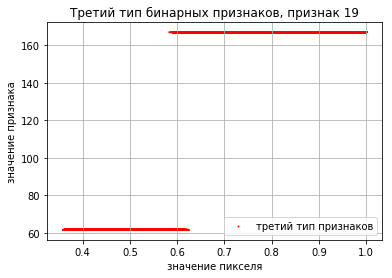

Признак 20, возможные значения = 491.99726295750435 и 180.99567815468586


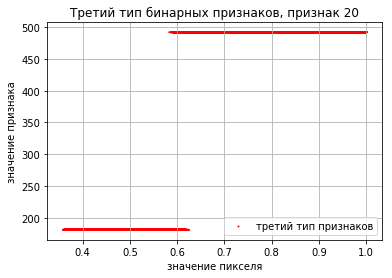

Признак 21, возможные значения = 208.23441716949512 и 76.60516102097486


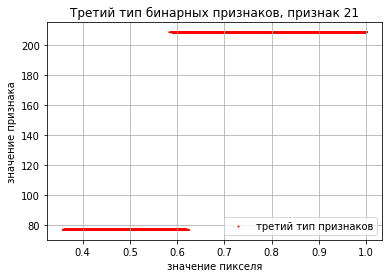

In [91]:
for features in bin_features_3:
    cur_str = str(features)
    cur_arr = pd.unique(train_df[cur_str])
    val_1 = cur_arr[0]
    val_2 = cur_arr[1]
    print("Признак {0}, возможные значения = {1} и {2}".format(features, val_1, val_2))
    x_axis = train_df['Y']
    y_axis = train_df[cur_str]
    fig = plt.figure()

    plt.xlabel('значение пикселя') 
    plt.ylabel('значение признака') 
    plt.title('Третий тип бинарных признаков, признак {0}'.format(features)) 

    s = [1 for n in range(x_axis.shape[0])]
    plt.scatter(x_axis, y_axis, label = 'третий тип признаков', s = s, color = 'r')

    plt.legend()
    plt.grid(True) 
    plt.show()

Здесь порог тоже около $0.6$ и тоже размыт.
Посмотрим на аналогичную зависимость для оставшихся признаков с номерами $3,4,8,9,22-29$.

Признак 3


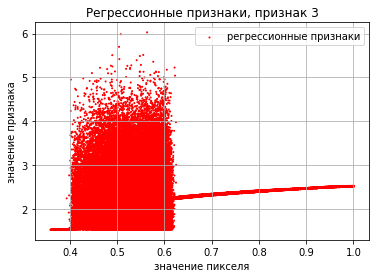

Признак 4


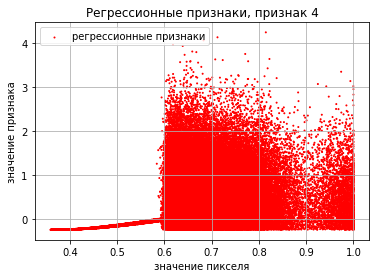

Признак 8


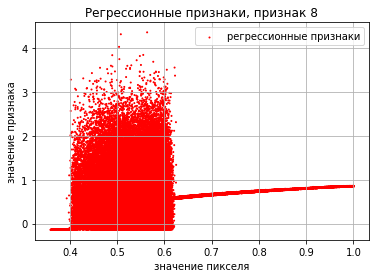

Признак 9


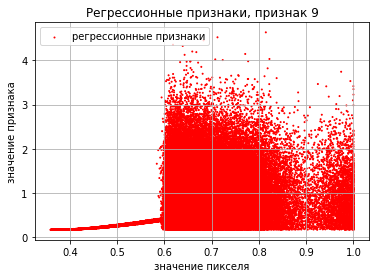

Признак 22


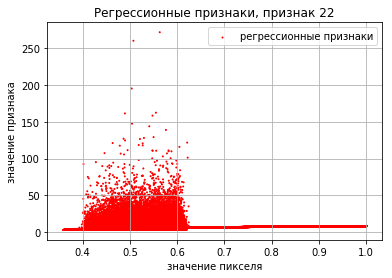

Признак 23


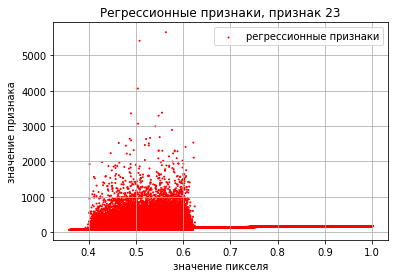

Признак 24


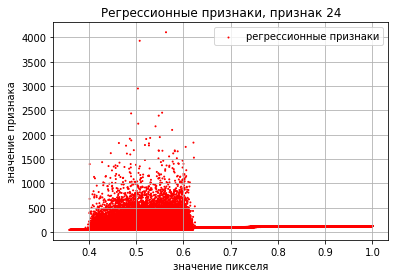

Признак 25


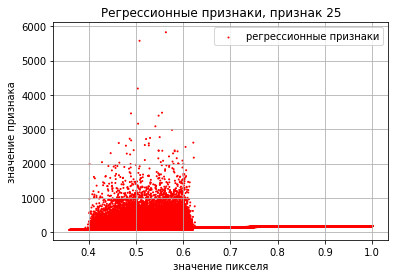

Признак 26


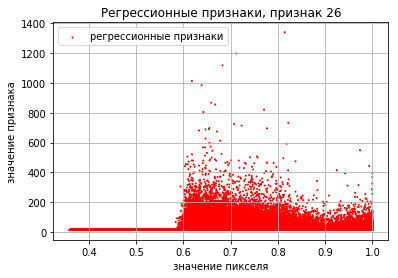

Признак 27


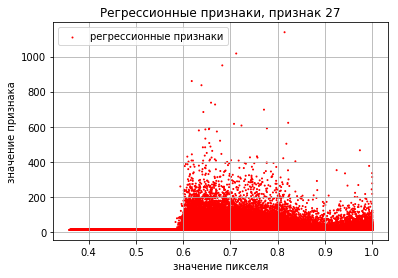

Признак 28


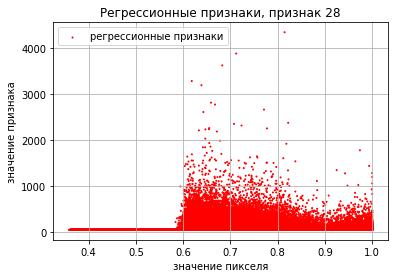

Признак 29


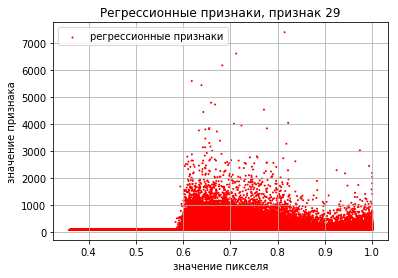

In [146]:
features_regression = [3, 4, 8, 9] + [i for i in range(22, 30)]
for features in features_regression:
    cur_str = str(features)
    cur_arr = pd.unique(train_df[cur_str])
    print("Признак {0}".format(features, val_1, val_2))
    x_axis = train_df['Y']
    y_axis = train_df[cur_str]
    fig = plt.figure()

    plt.xlabel('значение пикселя') 
    plt.ylabel('значение признака') 
    plt.title('Регрессионные признаки, признак {0}'.format(features)) 

    s = [1 for n in range(x_axis.shape[0])]
    plt.scatter(x_axis, y_axis, label = 'регрессионные признаки', s = s, color = 'r')

    plt.legend()
    plt.grid(True) 
    plt.show()

# Выводы по первичному анализу признаков:

1) первый тип бинарных признаков с номерами $0, 5, 10, 11, 12, 13$ приблизительно определяется порогом около $0.4$

2) второй тип бинарных признаков с номерами $1, 6, 14, 15, 16, 17$ приблизительно определяется порогами около $0.4$ и $0.6$

3) третий тип бинарных признаков с номерами $2, 7, 18, 19, 20, 21$ приблизительно определяется порогом около $0.6$

4) признаки с номерами $30, 31, 32, 33, 34$ имеют одно и то же значения для всех пикселей, они неинформативны.

Таким образом, для предсказания значений в пикселях попробуем для начала линейную регрессию по признакам с номерами $3, 4, 8, 9, 22-29$. Интересно заметить, что зависимость значений в пикселях от этих признаков распадается на 2 области - плавную кривую в одной части (левой или правой) и хаотическое поведение в оставшейся.

# Простая линейная регрессия

In [147]:
X_train_dict_regr = {'Y': y_train}
for i in features_regression:
    cur_string = 'X' + str(i)
    X_train_dict_regr[cur_string] = X_train[:, i]
    
train_df_regr = pd.DataFrame(X_train_dict_regr)

In [148]:
train_df_regr.head()

,Y,X3,X4,X8,X9,X22,X23,X24,X25,X26,X27,X28,X29
0,0.658741,2.288549,0.859431,0.624677,1.256353,6.467641,134.644964,97.718728,138.643103,45.607623,38.750030,147.605407,252.427767
1,0.671523,2.293655,-0.079660,0.629783,0.317261,6.500748,135.334184,98.218930,139.352788,17.831804,15.150602,57.711200,98.694957
2,0.660211,2.296195,1.243614,0.632323,1.640535,6.517282,135.678401,98.468746,139.707226,66.970839,56.901059,216.745739,370.668282
3,0.662597,2.296195,0.714635,0.632323,1.111556,6.517282,135.678401,98.468746,139.707226,39.459637,33.526459,127.707943,218.400068
4,0.658827,2.288549,0.422087,0.624677,0.819008,6.467641,134.644964,97.718728,138.643103,29.451076,25.022793,95.316041,163.004973


In [149]:
X_train_regr = X_train[:, 3]
for i in features_regression:
    if i != 3:
        X_train_regr = np.column_stack((X_train_regr, X_train[:, i]))
X_train_regr[0]

array([  2.288549  ,   0.85943114,   0.62467683,   1.25635252,
         6.46764108, 134.64496448,  97.71872794, 138.64310298,
        45.60762317,  38.75003034, 147.60540728, 252.42776687])

In [150]:
X_test_regr = X_test[:, 3]
for i in features_regression:
    if i != 3:
        X_test_regr = np.column_stack((X_test_regr, X_test[:, i]))

In [151]:
olsmod = sm.OLS(y_train, X_train_regr)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 2.971e+04
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:57:08   Log-Likelihood:             1.7190e+05
No. Observations:              172744   AIC:                        -3.438e+05
Df Residuals:                  172739   BIC:                        -3.437e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3229      0.000   1348.284      0.0

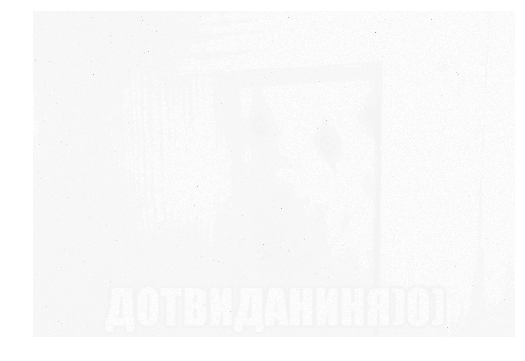

In [152]:
y_plot_test_1 = np.zeros((data_x_test.shape[0], data_x_test.shape[1]))
for i in range(test_len_x):
    for j in range(test_len_y):
        data_x_test_cur = [data_x_test[i][j][feat] for feat in features_regression]
        y_plot_test_1[i][j] = olsres.predict(data_x_test_cur)

show_img(y_plot_test_1)

Пока получилось достаточно размыто, хотя общая картина понятна. 
Попробуем какую-нибудь обобщённо-линейную модель, например, лог. регрессию.


# Логистическая регрессия

In [153]:
model_2 = sm.GLM(y_train, X_train_regr, family=sm.families.Binomial()).fit()

In [154]:
print(model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               172744
Model:                            GLM   Df Residuals:                   172739
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76121.
Date:                Sat, 27 Apr 2019   Deviance:                       6555.0
Time:                        22:58:03   Pearson chi2:                 7.95e+03
No. Iterations:                   100   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1634      0.006     28.435      0.000       0.152       0.175
x2             0.4498      0.010     42.932      0.0

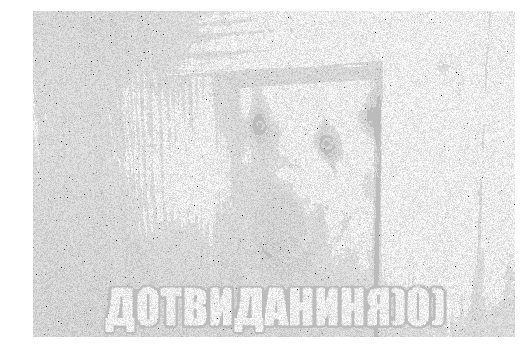

In [155]:
y_plot_test_2 = np.zeros((data_x_test.shape[0], data_x_test.shape[1]))
for i in range(test_len_x):
    for j in range(test_len_y):
        data_x_test_cur = [data_x_test[i][j][feat] for feat in features_regression]
        y_plot_test_2[i][j] = model_2.predict(data_x_test_cur)

show_img(y_plot_test_2)

Сравним с предыдущей картинкой. 

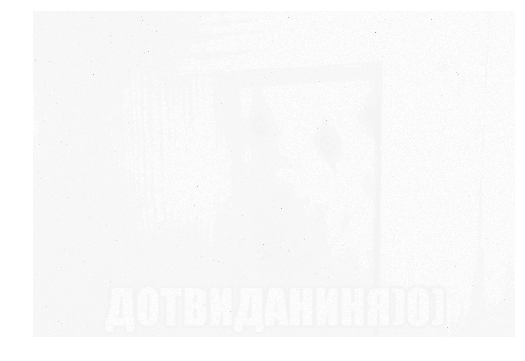

In [156]:
show_img(y_plot_test_1)

Вторая модель немного лучше, контрастность немного больше. Но всё ещё не очень. Посмотрим на остатки в первой модели.

((array([-4.46451263, -4.27077311, -4.16557079, ...,  4.16557079,
          4.27077311,  4.46451263]),
  array([-0.19374378, -0.19016104, -0.190029  , ...,  1.65738027,
          1.73922139,  1.79882912])),
 (0.0861946527620886, 2.936751057279328e-15, 0.9635621969001276))

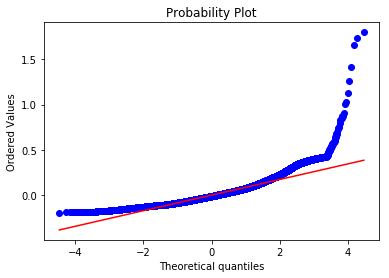

In [157]:
st.probplot(olsres.resid, plot=plt)

In [158]:
print (st.shapiro(olsres.resid))
print (st.wilcoxon(olsres.resid))

(0.9285594820976257, 0.0)
WilcoxonResult(statistic=6668840671.0, pvalue=0.0)


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [159]:
olsres.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                F  P>F  df constraint  df denom
x1   1.817870e+06  0.0             12  172739.0
x2   6.156345e+03  0.0             12  172739.0
x3   3.741974e+04  0.0             12  172739.0
x4   1.094830e+05  0.0             12  172739.0
x5   1.298810e+04  0.0             12  172739.0
x6   1.298810e+04  0.0             12  172739.0
x7   1.298810e+04  0.0             12  172739.0
x8   1.298810e+04  0.0             12  172739.0
x9   1.400804e+04  0.0             12  172739.0
x10  1.400804e+04  0.0             12  172739.0
x11  1.400804e+04  0.0             12  172739.0
x12  1.400804e+04  0.0             12  172739.0

Попробуем также сделать те же регрессии с учётом бинарных признаков.

# Регрессия с учётом бинарных признаков

In [162]:
X_train_regr_all = X_train[:, 0]
for i in range(30):
    if i != 3:
        X_train_regr_all = np.column_stack((X_train_regr_all, X_train[:, i]))

In [163]:
olsmod_all = sm.OLS(y_train, X_train_regr_all)
olsres_all = olsmod_all.fit()
print(olsres_all.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                 6.157e+04
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:05:56   Log-Likelihood:             2.2548e+05
No. Observations:              172744   AIC:                        -4.509e+05
Df Residuals:                  172737   BIC:                        -4.509e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.376e+05   2.27e+05      0.607      0.5

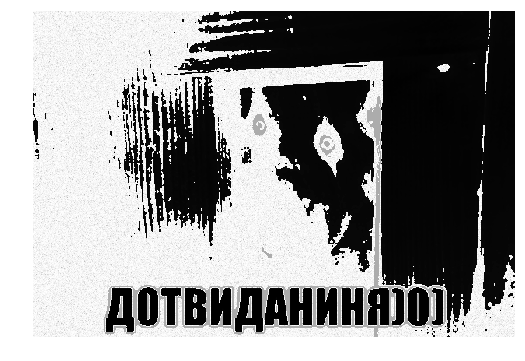

In [166]:
y_plot_test_3 = np.zeros((data_x_test.shape[0], data_x_test.shape[1]))
for i in range(test_len_x):
    for j in range(test_len_y):
        data_x_test_cur = [data_x_test[i][j][feat] for feat in range(30)]
        y_plot_test_3[i][j] = olsres_all.predict(data_x_test_cur)

show_img(y_plot_test_3)

Кажется, что цвета инвертировались. 

В итоге все восстановленные картинки получились не очень, мне сложно интерпретировать регрессионные признаки. Очень хочется узнать их смысл. 